<a href="https://colab.research.google.com/github/AMHB/Multi-Layered-Security-Enhancement-of-IIOT-in-Open-RAN/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In below we have implemented a step by step guide with code for the implementation section of our paper titled as: "A Multi-Layered Security Framework for IIoT in TrustORAN using Blockchain and Federated Tiny Machine Learning".

***Table of Contents:***
* Step 1: Data Preparation and Simulating IIoT Devices
* Step 2: Implementing Transfer Learning (TL) and Federated Learning (FL)
* Step 3: Anomaly Detection and Reporting
* Step 4: Policy Enforcement via Access Control Contract (ACC)
* Step 5: Model Evaluation and Comparison

Required Libraries:

In [22]:
# ────────────────────────────────────────────────────────────────
# Cell 1 – Environment Check & Imports
#
# • Ensure core libraries are installed (Colab may pre-install, but
#   in case TensorFlow is missing we explicitly install it here).
# • Import everything needed for data prep, ML models, and metrics.
# • Print versions to confirm environment.
# ────────────────────────────────────────────────────────────────

# 1️⃣ Install missing core packages (quietly, only installs what’s absent)
#    - Note: if these are already present, pip will skip or upgrade harmlessly.
!pip install -q tensorflow scikit-learn lightgbm dask seaborn pandas numpy

# 2️⃣ Now import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn
import lightgbm as lgb
import dask

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection  import train_test_split
from sklearn.metrics         import (
    roc_curve, auc, confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.ensemble       import RandomForestClassifier
from sklearn.neighbors     import KNeighborsClassifier
from sklearn.svm           import SVC

# 3️⃣ Version check
print("Library versions:")
print(f"  pandas:       {pd.__version__}")
print(f"  numpy:        {np.__version__}")
print(f"  scikit-learn: {sklearn.__version__}")
print(f"  tensorflow:   {tf.__version__}")
print(f"  lightgbm:     {lgb.__version__}")
print(f"  dask:         {dask.__version__}")


Library versions:
  pandas:       2.2.2
  numpy:        1.26.4
  scikit-learn: 1.6.1
  tensorflow:   2.18.0
  lightgbm:     4.5.0
  dask:         2024.12.1


In [23]:
# ────────────────────────────────────────────────────────────────
# Cell 2 – Mount Google Drive at /content/drive
#
# 1️⃣ This makes everything in “MyDrive” available under
#     /content/drive/MyDrive
# 2️⃣ Then Cell 3 can read from /content/drive/MyDrive/… directly
# ────────────────────────────────────────────────────────────────

from google.colab import drive
drive.mount('/content/drive')    # ← mount your entire Drive at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# ────────────────────────────────────────────────────────────────
# Cell 3 – Data Ingest & Train/Test Split (with sanity checks)
#
# 1️⃣ Load the combined CSV
# 2️⃣ Ensure it’s non-empty and has a ‘label’ column
# 3️⃣ Drop any missing labels
# 4️⃣ Do a stratified 80/20 TRAIN/TEST split
# 5️⃣ Assert both splits are non-empty before saving
# ────────────────────────────────────────────────────────────────

import pandas as pd
from sklearn.model_selection import train_test_split

# 1️⃣ Load the full dataset
path = '/content/drive/MyDrive/Colab/ORAN_Security_IWCMC_2025/train_test_network.csv'
dataset = pd.read_csv(path)
print("✅ Loaded dataset:", path)
print("  • Shape:", dataset.shape)
print("  • Columns:", list(dataset.columns))
print(dataset.head(), "\n")

# 2️⃣ Verify we have at least one row and the label column exists
if dataset.empty:
    raise ValueError(f"Loaded dataset is empty! Check that '{path}' is correct.")
if 'label' not in dataset.columns:
    raise ValueError("No 'label' column found in the dataset.")

# 3️⃣ Clean: drop rows missing the target label
before = dataset.shape[0]
dataset.dropna(subset=['label'], inplace=True)
after  = dataset.shape[0]
print(f"  • Dropped {before-after} rows with missing labels; {after} remain.\n")

# 4️⃣ Stratified 80/20 split
train_df, test_df = train_test_split(
    dataset,
    test_size=0.20,
    random_state=42,
    stratify=dataset['label']
)
print(f"✅ TRAIN split: {train_df.shape}  |  TEST split: {test_df.shape}")
print("  • TRAIN class ratios:", train_df['label'].value_counts(normalize=True).to_dict())
print("  • TEST  class ratios:", test_df ['label'].value_counts(normalize=True).to_dict(), "\n")

# 5️⃣ Sanity-check non-emptiness before saving
if train_df.empty or test_df.empty:
    raise ValueError("One of the splits is empty! Check your input data and stratification.")

# Save to CSV for downstream cells
train_df.to_csv(
    '/content/drive/MyDrive/Colab/ORAN_Security_IWCMC_2025/train_network.csv',
    index=False
)
test_df.to_csv(
    '/content/drive/MyDrive/Colab/ORAN_Security_IWCMC_2025/test_network.csv',
    index=False
)
print("✅ Saved train_network.csv & test_network.csv")



✅ Loaded dataset: /content/drive/MyDrive/Colab/ORAN_Security_IWCMC_2025/train_test_network.csv
  • Shape: (178228, 44)
  • Columns: ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth', 'http_method', 'http_uri', 'http_version', 'http_request_body_len', 'http_response_body_len', 'http_status_code', 'http_user_agent', 'http_orig_mime_types', 'http_resp_mime_types', 'weird_name', 'weird_addl', 'weird_notice', 'label', 'type']
          src_ip  src_port         dst_ip  dst_port proto service    duration  \
0   192.168.1.37      4444  192.168.1.193     49178   tcp       -  290.371539   
1  192.168.1.193     49180   192.168.1.37      8080   tcp       

In [27]:
# ────────────────────────────────────────────────────────────────
# Cell 4 – Data Preparation & Feature Selection
#
# 1️⃣  Load the TRAIN / TEST splits created in Cell 3 and assert non-emptiness
# 2️⃣  Drop any rows still missing the target label
# 3️⃣  Remove “leaky” or high-cardinality columns that shouldn’t be modeled
# 4️⃣  Identify feature columns vs. the label
# 5️⃣  Label-encode any remaining non-numeric features
# 6️⃣  Standard-scale numeric features (fit on TRAIN only)
# 7️⃣  Shuffle TRAIN and split into 100 federated shards
# ────────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1️⃣ Load the 80/20 splits and sanity-check
train_df = pd.read_csv('/content/drive/MyDrive/Colab/ORAN_Security_IWCMC_2025/train_network.csv')
test_df  = pd.read_csv('/content/drive/MyDrive/Colab/ORAN_Security_IWCMC_2025/test_network.csv')
assert not train_df.empty, "❌ train_network.csv is empty — check your Cell 3!"
assert not test_df .empty, "❌ test_network.csv is empty — check your Cell 3!"

# 2️⃣ Drop any rows without a label
train_df.dropna(subset=['label'], inplace=True)
test_df .dropna(subset=['label'], inplace=True)

# 3️⃣ Remove “leaky” / high-cardinality columns
drop_cols = [
    'src_ip','src_port','dst_ip','dst_port',
    'dns_query','http_uri','http_user_agent',
    'http_orig_mime_types','http_resp_mime_types',
    'ssl_subject','ssl_issuer',
    'weird_name','weird_addl','weird_notice','type'
]
train_df.drop(columns=drop_cols, errors='ignore', inplace=True)
test_df .drop(columns=drop_cols, errors='ignore', inplace=True)

# 4️⃣ Identify features vs. label
feature_cols = train_df.columns.difference(['label'])
y_train = train_df['label']
y_test  = test_df ['label']

# 5️⃣ Encode any remaining non-numeric (low-cardinality) columns
encoder      = LabelEncoder()
non_num_cols = train_df.select_dtypes(exclude=np.number).columns
for col in non_num_cols:
    encoder.fit(pd.concat([train_df[col], test_df[col]]).unique())
    train_df[col] = encoder.transform(train_df[col])
    test_df [col] = encoder.transform(test_df [col])

# 6️⃣ Standard-scale numeric features (fit on TRAIN only)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(train_df[feature_cols]),
    columns=feature_cols
)
X_test_scaled = pd.DataFrame(
    scaler.transform(test_df[feature_cols]),
    columns=feature_cols
)

# 7️⃣ Shuffle TRAIN and split into 100 federated device shards
train_shuffled = X_train_scaled.copy()
train_shuffled['label'] = y_train.values
train_shuffled = train_shuffled.sample(frac=1, random_state=42).reset_index(drop=True)

num_devices = 100
X_splits = np.array_split(train_shuffled.drop('label', axis=1), num_devices)
y_splits = np.array_split(train_shuffled['label'],               num_devices)
device_data = list(zip(X_splits, y_splits))

print(f"✅ Features used: {len(feature_cols)} columns after drop")
print(f"✅ Prepared {num_devices} device shards; first shard has {len(X_splits[0])} samples")


✅ Features used: 28 columns after drop
✅ Prepared 100 device shards; first shard has 1426 samples



Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/20
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9418 - loss: 0.1785 - val_accuracy: 0.9473 - val_loss: 0.1187 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/20
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9496 - loss: 0.1162 - val_accuracy: 0.9498 - val_loss: 0.0994 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/20
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9594 - loss: 0.1049 - val_accuracy: 0.9504 - val_loss: 0.1167 - learning_rate: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/20
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9658 - loss: 0.0982 - val_accuracy: 0.9881 - val_loss: 0.0723 - learning_rate: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/20
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy

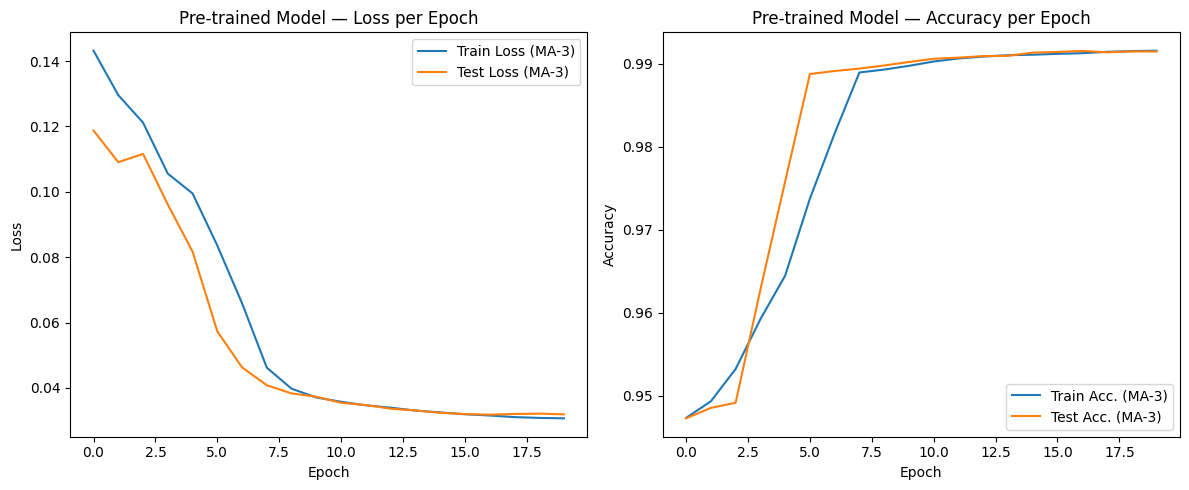

In [28]:
# ────────────────────────────────────────────────────────────────
# Cell 5 – Neural-Network Global Pre-training (Sharper Start)
# • Pre-train on ALL of TRAIN (80 %) and validate on TEST (20 %)
# • Two 64-unit ReLU layers → sigmoid; Adam optimizer with warm LR
# • Starts at 1e-2 for 5 epochs, then drops to 1e-3 for the remainder
# • Runs exactly 20 epochs, smoothing for the plots only
# ────────────────────────────────────────────────────────────────

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# 1️⃣ Build & compile the simple 2×64 MLP
def create_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1,  activation='sigmoid')
    ])
    # We will override the LR via scheduler
    model.compile(
        optimizer=Adam(learning_rate=1e-2),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_model(X_train_scaled.shape[1])

# 2️⃣ Learning-rate schedule: high LR for first 5 epochs, then lower
def lr_schedule(epoch):
    if epoch < 5:
        return 1e-2
    else:
        return 1e-3

lr_cb = LearningRateScheduler(lr_schedule, verbose=1)

# 3️⃣ Pre-train on full TRAIN, validate on TEST (no internal split)
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=20,
    batch_size=32,
    shuffle=True,
    callbacks=[lr_cb],
    verbose=1
)

# 4️⃣ Smooth 3-epoch moving average for plotting only
def smooth(x, k=3):
    return pd.Series(x).rolling(window=k, min_periods=1).mean()

train_loss = smooth(history.history['loss'])
test_loss  = smooth(history.history['val_loss'])
train_acc  = smooth(history.history['accuracy'])
test_acc   = smooth(history.history['val_accuracy'])

# 5️⃣ Plot Loss & Accuracy Fig 1/Fig 2
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_loss, label='Train Loss (MA-3)')
plt.plot(test_loss,  label='Test Loss (MA-3)')
plt.title('Pre-trained Model — Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Acc. (MA-3)')
plt.plot(test_acc,  label='Test Acc. (MA-3)')
plt.title('Pre-trained Model — Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [29]:
# ────────────────────────────────────────────────────────────────
# Cell 6 – NeuralNetwork_TL Federated Transfer Learning (Revised)
#
# • Re-splits the TRAIN shard into 100 for FL
# • Clones w₀ (`model`) → fine-tunes 10 epochs per shard
# • FedAvg → new global w₁
# • Evaluates w₁ on TEST (loss, acc) + AUC/F1/etc.
# ────────────────────────────────────────────────────────────────

import warnings
warnings.filterwarnings("ignore", message=".*swapaxes.*deprecated.*")

import numpy as np
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# The “global” model you pre-trained in Cell 5:
global_model = model

# 0️⃣ Re-create 100 device shards from X_train_scaled / y_train
num_devices = 100
X_splits = np.array_split(X_train_scaled, num_devices)
y_splits = np.array_split(y_train,       num_devices)
device_data = list(zip(X_splits, y_splits))

# 1️⃣–2️⃣ Clone & fine-tune per shard
local_losses, local_accs, local_models = [], [], []
for X_dev, y_dev in device_data:
    m = clone_model(global_model)
    m.set_weights(global_model.get_weights())
    m.compile(optimizer=Adam(1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    h = m.fit(X_dev, y_dev,
              epochs=10,
              batch_size=32,
              verbose=0)
    local_losses.append(h.history['loss'][-1])
    local_accs.append(h.history['accuracy'][-1])
    local_models.append(m)

# 3️⃣ FedAvg aggregation
def fed_avg(models):
    return [np.mean(ws, axis=0)
            for ws in zip(*[m.get_weights() for m in models])]

new_weights = fed_avg(local_models)
global_model.set_weights(new_weights)

# 4️⃣ Evaluate w₁ on TEST
test_loss, test_acc = global_model.evaluate(X_test_scaled, y_test, verbose=0)

# 5️⃣ Compute additional metrics
y_prob = global_model.predict(X_test_scaled).ravel()
y_pred = (y_prob > 0.5).astype(int)
prec   = precision_score(y_test, y_pred)
rec    = recall_score(y_test, y_pred)
f1     = f1_score(y_test, y_pred)
auc    = roc_auc_score(y_test, y_prob)

print(f"NN Local Avg → Loss: {np.mean(local_losses):.4f}, Acc: {np.mean(local_accs):.4f}")
print(f"Global NN w₁ → Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")



1114/1114 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
NN Local Avg → Loss: 0.0250, Acc: 0.9928
Global NN w₁ → Test Loss: 0.0345, Acc: 0.9914
Precision: 0.9917, Recall: 0.9964, F1: 0.9940, AUC: 0.9978


In [30]:
# ────────────────────────────────────────────────────────────────
# Cell 7 – LightGBM_TL Pre-train & Device-Level TL
#
# • Pre-train on reduced TRAIN (100 rounds)
# • Fine-tune each shard 50 rounds from init model
# • Pick the shard model with highest AUC on TEST as LightGBM_TL
# ────────────────────────────────────────────────────────────────

import lightgbm as lgb
from sklearn.metrics import roc_auc_score

params = {
    'objective':'binary','metric':'binary_logloss',
    'learning_rate':0.05,'num_leaves':31,
    'feature_fraction':0.9,'bagging_fraction':0.8,
    'bagging_freq':5,'verbosity':-1,'seed':42
}

# 1️⃣ Pre-train
ds_full = lgb.Dataset(X_train_scaled, label=y_train)
global_lgb = lgb.train(params, ds_full, num_boost_round=100)

# 2️⃣ Fine-tune shards & evaluate
best_auc, best_lgb = 0.0, None
for X_dev, y_dev in device_data:
    ds_dev = lgb.Dataset(X_dev, label=y_dev)
    m_dev  = lgb.train(params, ds_dev, num_boost_round=50, init_model=global_lgb)
    auc_i  = roc_auc_score(y_test, m_dev.predict(X_test_scaled))
    if auc_i > best_auc:
        best_auc, best_lgb = auc_i, m_dev

print(f"Selected LightGBM_TL with AUC = {best_auc:.4f}")


Selected LightGBM_TL with AUC = 0.9999


In [31]:
# ────────────────────────────────────────────────────────────────
# Cell 8 – Classical ML (RF, KNN, SVM) Device-Level TL
#
# • Train RF/KNN/SVM on each of 100 shards using reduced features
# • Evaluate each on TEST, pick highest-AUC model per algorithm
# • Stores as global_ml for final evaluation
# ────────────────────────────────────────────────────────────────

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

bases = {
    'RF':  RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42)
}

global_ml = {}
for name, base in bases.items():
    best_auc, best_model = 0.0, None
    for X_dev, y_dev in device_data:
        m = base.__class__(**base.get_params())
        m.fit(X_dev, y_dev)
        auc_i = roc_auc_score(y_test, m.predict_proba(X_test_scaled)[:,1])
        if auc_i > best_auc:
            best_auc, best_model = auc_i, m
    global_ml[name] = best_model
    print(f"Selected {name}_No_TL with AUC = {best_auc:.4f}")


Selected RF_No_TL with AUC = 0.9995
Selected KNN_No_TL with AUC = 0.9949
Selected SVM_No_TL with AUC = 0.9584


1114/1114 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
TABLE I: Model Evaluation Metrics
                  Accuracy Precision    Recall  F1 Score       AUC
RF_No_TL          0.993071  0.992821  0.997582  0.995196  0.999549
KNN_No_TL         0.986506  0.988546  0.992747  0.990642  0.994933
SVM_No_TL          0.94263  0.937428   0.98608  0.961139  0.958359
LightGBM_TL       0.995792  0.996301  0.997855  0.997078  0.999866
NeuralNetwork_TL  0.991388  0.991657  0.996413  0.994029  0.997804


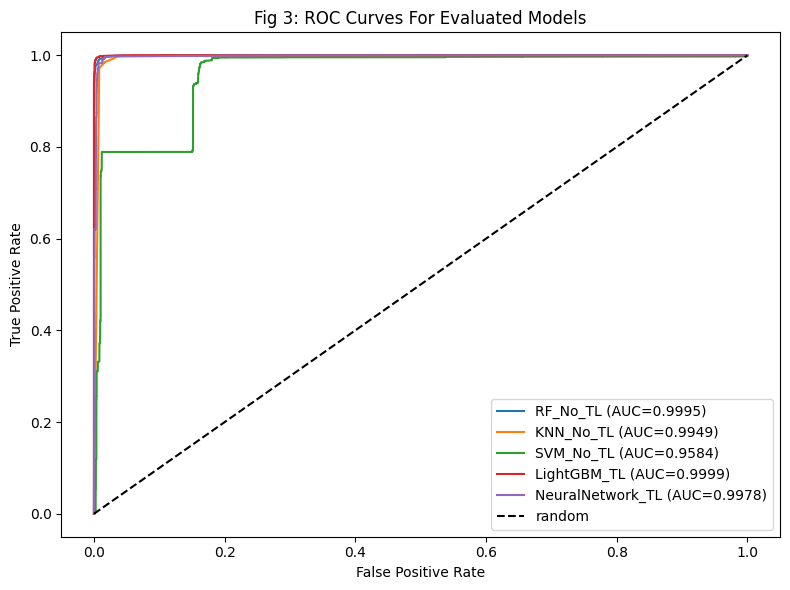

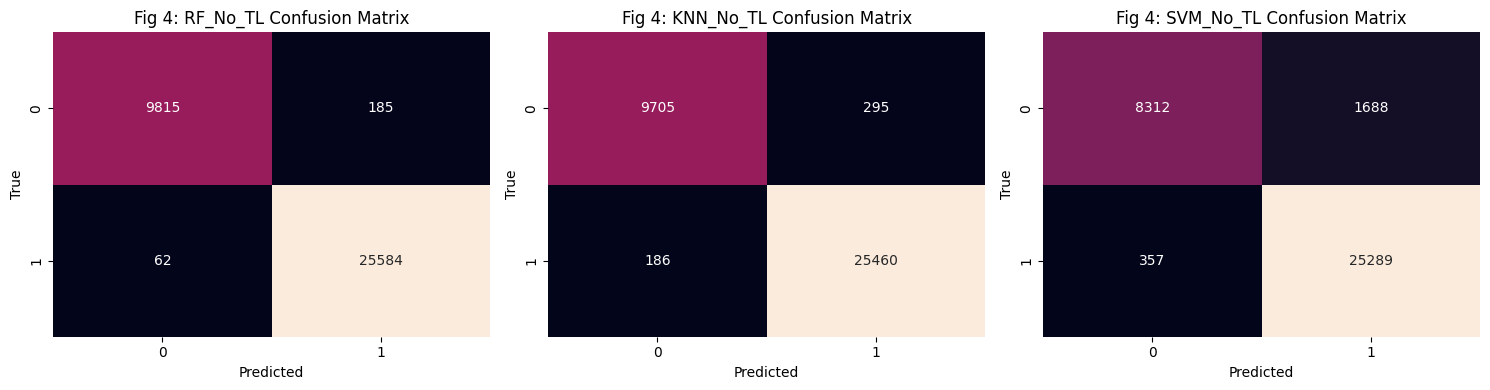

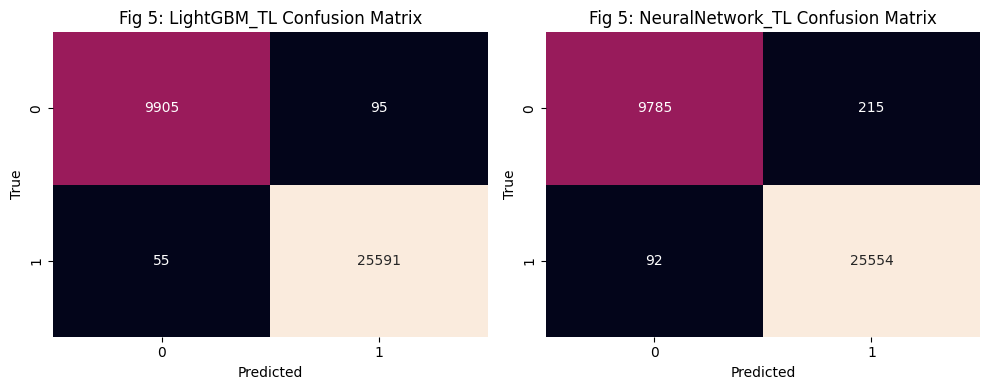

In [32]:
# ────────────────────────────────────────────────────────────────
# Cell 9 – Final Evaluation & Results Visualization (Revised)
#
# • Evaluates RF_No_TL, KNN_No_TL, SVM_No_TL, LightGBM_TL, NeuralNetwork_TL
# • Compiles Table I and plots Fig 3 (ROC), Fig 4 & Fig 5 (CMs)
# ────────────────────────────────────────────────────────────────

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, auc, confusion_matrix
)

# 1️⃣ Eval helper
def eval_model(name, model):
    # get probabilities
    if hasattr(model, 'predict_proba'):
        prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        prob = model.predict(X_test_scaled).ravel()
    pred = (prob > 0.5).astype(int)

    # metrics
    acc  = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec  = recall_score(y_test, pred)
    f1   = f1_score(y_test, pred)
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_a = auc(fpr, tpr)
    cm   = confusion_matrix(y_test, pred)

    return {
        'Accuracy':   acc,
        'Precision':  prec,
        'Recall':     rec,
        'F1 Score':   f1,
        'AUC':        roc_a,
        'FPR':        fpr,
        'TPR':        tpr,
        'CM':         cm
    }

# 2️⃣ Build results dict
results = {
    'RF_No_TL':         eval_model('RF_No_TL',         global_ml['RF']),
    'KNN_No_TL':        eval_model('KNN_No_TL',        global_ml['KNN']),
    'SVM_No_TL':        eval_model('SVM_No_TL',        global_ml['SVM']),
    'LightGBM_TL':      eval_model('LightGBM_TL',      best_lgb),
    'NeuralNetwork_TL': eval_model('NeuralNetwork_TL', global_model)
}

df = pd.DataFrame(results).T
print("TABLE I: Model Evaluation Metrics")
print(df[['Accuracy','Precision','Recall','F1 Score','AUC']].round(4))

# Fig 3: ROC curves
plt.figure(figsize=(8,6))
for nm, row in df.iterrows():
    plt.plot(row['FPR'], row['TPR'], label=f"{nm} (AUC={row['AUC']:.4f})")
plt.plot([0,1],[0,1],'k--', label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Fig 3: ROC Curves For Evaluated Models')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Fig 4: Confusion matrices for RF, KNN, SVM
fig, axes = plt.subplots(1,3,figsize=(15,4))
for ax, name in zip(axes, ['RF_No_TL','KNN_No_TL','SVM_No_TL']):
    sns.heatmap(df.loc[name,'CM'], annot=True, fmt='d', cbar=False, ax=ax)
    ax.set_title(f'Fig 4: {name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
plt.tight_layout()
plt.show()

# Fig 5: Confusion matrices for LightGBM_TL & NeuralNetwork_TL
fig, axes = plt.subplots(1,2,figsize=(10,4))
for ax, name in zip(axes, ['LightGBM_TL','NeuralNetwork_TL']):
    sns.heatmap(df.loc[name,'CM'], annot=True, fmt='d', cbar=False, ax=ax)
    ax.set_title(f'Fig 5: {name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
plt.tight_layout()
plt.show()
